---

<div align='center'>
<font size="+2">

Text Mining and Natural Language Processing  
2023-2024

<b>SelectWise</b>

Alessandro Ghiotto 513944

</font>
</div>

---

# Notebook 2 - Word Embeddings:
1. Representation by means of static word embeddings:
    - Word2Vec
    - GloVE
    - FastText
    - Doc2Vec
2. Other ways of combining word embeddings:
    - Remove duplicated words
    - Word embeddings weighted by their idf score
3. Other ways of choosing the answer:
    - Siamese Neural Network
    - Feed Forward Neural Network


---

Reload data as in notebook1

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

dataset = load_dataset("allenai/qasc")

seed = 8

def format_choices(df):
    choices = df['choices'].apply(pd.Series)
    correct_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    for labels in choices['label']:
        if labels != correct_order:
            raise ValueError(f"Labels are not in the correct order: {labels}")
    for i, label in enumerate(correct_order):
        df[label] = choices['text'].apply(lambda x: x[i])
    df = df.drop(columns=['choices'])
    return df

n_train_sample = 7323
df_train = format_choices(pd.DataFrame(dataset['train'][:n_train_sample]))
df_val = format_choices(pd.DataFrame(dataset['train'][n_train_sample:]))
df_test = format_choices(pd.DataFrame(dataset['validation']))

answerKey_train = df_train['answerKey']
answerKey_val = df_val['answerKey']
answerKey_test = df_test['answerKey']

df_train['facts_and_question'] = df_train['fact1'] + ' ' + df_train['fact2'] + ' ' + df_train['question']
df_val['facts_and_question'] = df_val['fact1'] + ' ' + df_val['fact2'] + ' ' + df_val['question']
df_test['facts_and_question'] = df_test['fact1'] + ' ' + df_test['fact2'] + ' ' + df_test['question']
 
# Display the updated DataFrame
print(df_train.iloc[0])

id                                       3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K
question              What type of water formation is formed by clouds?
answerKey                                                             F
fact1                 beads of water are formed by water vapor conde...
fact2                                   Clouds are made of water vapor.
combinedfact                    Beads of water can be formed by clouds.
formatted_question    What type of water formation is formed by clou...
A                                                                pearls
B                                                               streams
C                                                                shells
D                                                              diamonds
E                                                                  rain
F                                                                 beads
G                                                               

# **Representation by means of static word embeddings**

- tokenize the question and the choices with NLTK (+ lowercase, remove stopwords and punctuation). 
- the representation of the sentence is compute by doing the mean of its word embeddings.
- as similarity score I use the cosine similarity of the question vector and the choice vector.
- the choice that had the highest cosine similarity is our prediction.

Training data for our word embeddings models -> all the sentences from `'question'`, `'fact1'` and `'fact2'` from the train set. (this sentences are preprocessed, lowercase, tokenize...). I will not use the possible choices as training data, since are usually very short, so we don't have a window in which we can use skip-gram or CBoW for training the model (we have no context to predict/we have no context to give as input for predicting the target word).

`'facts_and_question'` column will be used for the actual classifiaction task (not for training the mebeddings). Get the representation fo the` 'facts_and_question'`, take the representation of the `choices`, and compute similarity.

I will use **skip-gram** instead of **CBoW**, since we don't have so much training data (the sentences aren't very long). Skip-gram by trying to predict the whole context, instead of just predicting the middle word, it creates more "complete" word embeddings

![picture](../imgs/2_wordembeddings.png)

In [2]:
# Prepare the text docs

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# nltk.download('punkt')
# nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def nltk_tokenizer(sentence):
    # Lowercase all sentences
    sentence = sentence.lower()

    # Tokenize using nltk
    my_tokenized_tokens = word_tokenize(sentence)

    # Removing stop words and punctuations
    mytokens = [word for word in my_tokenized_tokens if word not in stopwords_list and word not in punctuations]

    return mytokens 


# Define the custom transformer
tokenizer_transformer = FunctionTransformer(lambda x: x.apply(nltk_tokenizer).to_frame(), validate=False)
columns_to_tokenize = ['facts_and_question', 'question', 'fact1', 'fact2', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
dataframe_tokenizer = ColumnTransformer(
    transformers=[(col, tokenizer_transformer, col) for col in columns_to_tokenize],
    remainder='drop'  # drop other columns
)

# Apply the column transformer to the DataFrame and convert the result to a DataFrame
df_train_tokenized = pd.DataFrame(dataframe_tokenizer.fit_transform(df_train), columns=columns_to_tokenize)
df_val_tokenized = pd.DataFrame(dataframe_tokenizer.fit_transform(df_val), columns=columns_to_tokenize)

df_train_tokenized.iloc[0]

facts_and_question    [beads, water, formed, water, vapor, condensin...
question                       [type, water, formation, formed, clouds]
fact1                  [beads, water, formed, water, vapor, condensing]
fact2                                      [clouds, made, water, vapor]
A                                                              [pearls]
B                                                             [streams]
C                                                              [shells]
D                                                            [diamonds]
E                                                                [rain]
F                                                               [beads]
G                                                              [cooled]
H                                                              [liquid]
Name: 0, dtype: object

In [3]:
# Stack the columns into a single column (our data -> a list of sentences)
train_sentences = df_train_tokenized[['question', 'fact1', 'fact2']].stack().reset_index()
train_sentences = train_sentences[0] # take the column with the sentences

# drop the columns that we have already stacked
df_train_tokenized = df_train_tokenized.drop(columns=['question', 'fact1', 'fact2'])

## Word2Vec

Here we train our model. I will use `k=300` and `window=5`. I have tried different window size, but the results are quite the same.

In [4]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
# print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
print("Training the W2V model on the train sentences, constituted by the questions, fact1 and fact2")
# sg=1 for using skip-gram
W2V_300 = Word2Vec(train_sentences, sg=1, vector_size=300, window=5, min_count=1, workers=cpu, seed=seed)
W2V_300.train(train_sentences, total_examples=len(train_sentences), epochs=50)
W2V_300_wv = W2V_300.wv # Word embeddings matrix
# W2V_300.save('../models/W2V_300.model') # Save the model
W2V_300_wv

Training the W2V model on the train sentences, constituted by the questions, fact1 and fact2


In [5]:
def sent_to_emb(sent, pretrained_vectors):
    vector_size = pretrained_vectors.vector_size    # dimension
    wv_res = np.zeros(vector_size)    # init the result vector
    # print(wv_res)
    ctr = 1
    for w in sent:    # iterate through our sentence--> w
        if w in pretrained_vectors:    # do we have that particular word present in our pretrained vectors
            ctr += 1    # we need to count them. Because for average we need to know how many in our sentences
            wv_res += pretrained_vectors.get_vector(w)    #  add vector representation of this particular word to result
    wv_res =  wv_res/ctr   # evetually added all the vectors associated with each word in the sentence (of the dataset) in
    # this final vector--> wv_res....and then divide by the number of words-> ctr
    # we could also take just the sum (instead of the average)
    return wv_res

ex_sentence = df_train_tokenized.iloc[0]['facts_and_question']
ex_sentence_emb = sent_to_emb(ex_sentence, W2V_300_wv)
print(ex_sentence_emb[:10], '...')
print('length of the embedding:', len(ex_sentence_emb))

[ 0.1874686  -0.07443899 -0.17019576  0.00520933 -0.46233277  0.0578984
  0.15393962 -0.06878021 -0.14262929 -0.01634399] ...
length of the embedding: 300


Now we just need to compute the similarity and compare them, this functions are the same from the previous notebook. The way of computinig the similarity is the same, just the representation of our documents is different.

In [7]:
import scipy
import torch
def cosine_similarity_btw2vec(v1, v2):
    if scipy.sparse.issparse(v1) and scipy.sparse.issparse(v2):
        v1 = v1.toarray().flatten()
        v2 = v2.toarray().flatten()
    if torch.is_tensor(v1) and torch.is_tensor(v2):
        v1 = v1.cpu().detach().numpy().flatten()
        v2 = v2.cpu().detach().numpy().flatten()
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0 
    return dot_product / (norm_v1 * norm_v2)


from sklearn.metrics import accuracy_score, f1_score

np.random.seed(seed)

def cosineSimilarity_predict(df_tokenized, pretrained_vectors, sent_to_emb=sent_to_emb):
    ### SENTENCE TO EMBEDDING ### 

    # apply the function to all the cols of the dataframe
    columns_to_embed = ['facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    df_emb = dict()
    for col in columns_to_embed:
        df_emb[col] = df_tokenized[col].apply(lambda x: sent_to_emb(x, pretrained_vectors))

    ### PREDICT ###

    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    # compute cosine similarity between 'facts_and_question' and each choice column
    similarity_scores = {}
    for choice in choices:
        similarity_scores[choice] = np.array([cosine_similarity_btw2vec(v1, v2) \
                                              for v1, v2 in zip(df_emb['facts_and_question'], df_emb[choice])])
    # convert the dictionary to a DataFrame (so we navigate along the rows)
    similarity_scores = pd.DataFrame(similarity_scores)
    # find the choice with the highest cosine similarity
    # since we have a pandas DataFrame, the argmax returns the column name ('A', 'B', 'C', ...)
    predicted_choices = similarity_scores.idxmax(axis=1)
    return predicted_choices


def evaluate_predictions(true_labels, predictions, dataset_label=None):
    # dataset_label is a string that specifies the dataset{'train', 'validation', 'test'}
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    print(f"{dataset_label} Accuracy:", accuracy)
    print(f"{dataset_label} F1 Score:", f1)
    return accuracy, f1

# load the model
W2V_300 = Word2Vec.load('../models/W2V_300.model')
print('W2V_300 - Word2Vec model trained on our dataset - k=300')
pred_train_W2V = cosineSimilarity_predict(df_train_tokenized, W2V_300_wv)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')

print('')
pred_val_W2V = cosineSimilarity_predict(df_val_tokenized, W2V_300_wv)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')

W2V_300 - Word2Vec model trained on our dataset - k=300
train Accuracy: 0.7431380581728799
train F1 Score: 0.7429122927407739

validation Accuracy: 0.55980271270037
validation F1 Score: 0.5589637168346118


We can say that the model is too much overfitted on the training data. Or maybe isn't simply overfitting, but the model just lacks information about the questions which are treated in the samples outside of the training data, since this questions are quite specific (it isn't trained on a simple corpus of text).

Now we can try to use `k=100` and see how much this impacts our results

In [34]:
W2V_100 = Word2Vec(train_sentences, sg=1, vector_size=100, window=5, min_count=1, workers=cpu, seed=seed)
W2V_100.train(train_sentences, total_examples=len(train_sentences), epochs=50)
W2V_100_wv = W2V_100.wv # Word embeddings matrix
# W2V_100.save('../models/W2V_100.model') # Save the model

W2V_100 = Word2Vec.load('../models/W2V_100.model')
print('W2V_100 - Word2Vec model trained on our dataset - k=100')
pred_train_W2V = cosineSimilarity_predict(df_train_tokenized, W2V_100_wv)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')

print('')
pred_val_W2V = cosineSimilarity_predict(df_val_tokenized, W2V_100_wv)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')

W2V_100 - Word2Vec model trained on our dataset - k=100
train Accuracy: 0.7398607128226137
train F1 Score: 0.739679781270694

validation Accuracy: 0.5573366214549939
validation F1 Score: 0.5568594960247641


The results are quite the same, so we don't need too much dimension for capturing all the informations needed for this task. At the end the topic covered in the questions are quite specific (science from elementary school), so it makes sense, we don't have too many words to be placed in our new embedding space

Now let's try with some pretrained Word2Vec model -> `'word2vec-google-news-300'`

In [35]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [36]:
pretrained_vectors = gensim.downloader.load('word2vec-google-news-300')

print('word2vec-google-news-300')
pred_train_W2V = cosineSimilarity_predict(df_train_tokenized, pretrained_vectors)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')
print('')
pred_val_W2V = cosineSimilarity_predict(df_val_tokenized, pretrained_vectors)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')

word2vec-google-news-300
train Accuracy: 0.638536119076881
train F1 Score: 0.6384703099957153

validation Accuracy: 0.6448828606658447
validation F1 Score: 0.6433593317369066


This results are much better, since the accuracy on the validation is much higher than before.

## GloVe

I will try with the following pretrained models -> `'glove-wiki-gigaword-100'` and `'glove-wiki-gigaword-300'`

In [37]:
### K=100 ###
pretrained_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

print('glove-wiki-gigaword-100')
pred_train_GloVe = cosineSimilarity_predict(df_train_tokenized, pretrained_vectors)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_GloVe, 'train')
print('')
pred_val_GloVe = cosineSimilarity_predict(df_val_tokenized, pretrained_vectors)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_GloVe, 'validation')

### K=300 ###
print('\n', '=='*20, '\n')
pretrained_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

print('glove-wiki-gigaword-300')
pred_train_GloVe = cosineSimilarity_predict(df_train_tokenized, pretrained_vectors)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_GloVe, 'train')
print('')
pred_val_GloVe = cosineSimilarity_predict(df_val_tokenized, pretrained_vectors)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_GloVe, 'validation')

glove-wiki-gigaword-100
train Accuracy: 0.3971050116072648
train F1 Score: 0.3969025434496839

validation Accuracy: 0.3797780517879161
validation F1 Score: 0.3790592823667349


glove-wiki-gigaword-300
train Accuracy: 0.5309299467431381
train F1 Score: 0.5308748827063896

validation Accuracy: 0.530209617755857
validation F1 Score: 0.5294781020912265


Here we can see the difference between `k=100` and `k=300`, this because for capturing all the words in the wikipedia corpus are required much more dimensions.

## FastText

As with Word2Vec, I will train the model on our dataset, and then try some pretrained model.

I still use skip-gram (`sg=1`), `k=300` and `k=100`, `window=5`

In [38]:
from gensim.models import FastText

### K=100 ###
FT_100 = FastText(train_sentences, sg=1, vector_size=100, window=5, min_count=1, workers=cpu, seed=seed)
FT_100.train(train_sentences, total_examples=len(train_sentences), epochs=50)
FT_100_wv = FT_100.wv # Word embeddings matrix
# FT_100.save('../models/FT_100.model') # Save the model

# FT_100 = Word2Vec.load('../models/FT_100.model')
print('FT_100 - FastText model trained on our dataset - k=100')
pred_train_FT = cosineSimilarity_predict(df_train_tokenized, FT_100_wv)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_FT, 'train')

print('')
pred_val_FT = cosineSimilarity_predict(df_val_tokenized, FT_100_wv)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_FT, 'validation')

print('\n', '=='*20, '\n')
### K=300 ###
FT_300 = FastText(train_sentences, sg=1, vector_size=300, window=5, min_count=1, workers=cpu, seed=seed)
FT_300.train(train_sentences, total_examples=len(train_sentences), epochs=50)
FT_300_wv = FT_300.wv # Word embeddings matrix
# FT_300.save('../models/FT_300.model') # Save the model

# FT_300 = Word2Vec.load('../models/FT_300.model')
print('FT_300 - FastText model trained on our dataset - k=300')
pred_train_FT = cosineSimilarity_predict(df_train_tokenized, FT_300_wv)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_FT, 'train')

print('')
pred_val_FT = cosineSimilarity_predict(df_val_tokenized, FT_300_wv)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_FT, 'validation')

FT_100 - FastText model trained on our dataset - k=100
train Accuracy: 0.7076334835449952
train F1 Score: 0.7075650227740629

validation Accuracy: 0.5807644882860666
validation F1 Score: 0.5789271112706209


FT_300 - FastText model trained on our dataset - k=300
train Accuracy: 0.7076334835449952
train F1 Score: 0.7075244445808855

validation Accuracy: 0.5745992601726264
validation F1 Score: 0.5727916477822823


The results with FastText are very similar with the ones obtained with Word2Vec

In [39]:
# pretrained model
pretrained_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

print('fasttext-wiki-news-subwords-300')
pred_train_FT = cosineSimilarity_predict(df_train_tokenized, pretrained_vectors)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_FT, 'train')
print('')
pred_val_FT = cosineSimilarity_predict(df_val_tokenized, pretrained_vectors)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_FT, 'validation')


fasttext-wiki-news-subwords-300
train Accuracy: 0.5230096954799945
train F1 Score: 0.522877765835515

validation Accuracy: 0.499383477188656
validation F1 Score: 0.4975633221474324


## Doc2Vec
The Doc2Vec algorithm represents each document by a dense vector which is trained to predict words in the document. Instead of building word embeddings (and then average them together for getting the representation of the sentence), here we try to directly build the vector representation of the whole document.

From the paper: "Paragraph Vector is capable of constructing representations
of input sequences of variable length. It is general and applicable to texts of
any length: sentences, paragraphs, and documents"

I will use the **Distributed Bag of Words** training algorithm (instead of Distributed Memory) - `dm=0`. In the DM architecture, the neural network takes two types of inputs:  the context words and a unique document ID. It acts as a memory that remembers what is missing from the current context. Instead with the DistributedBOW I try to predict the words in the paragraph, given the paragraph vector (it has a more complete view of the document, since it doesn't try to predict only what is "not remembered" from the words in the document).

![Doc2Vec](../imgs/2_doc2vec.png "Distributed Memory version of Paragraph Vector ")

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# create TaggedDocuments from our preprocessed training data
# data = train_sentences (list of already tokenized sentences)
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(train_sentences)]

# train the Doc2vec model
model = Doc2Vec(vector_size=100, min_count=1, epochs=50, dm=0, seed=seed)
model.build_vocab(tagged_data)
model.train(tagged_data,
			total_examples=model.corpus_count,
			epochs=model.epochs)
# save the model
# model.save('../models/D2V_100.model')

# get the document vector for an example
# we use the infer_vector method
example_sentence = df_train_tokenized.iloc[0]['facts_and_question']
document_vector = model.infer_vector(example_sentence)
print("Document:", example_sentence)
print("Vector:", document_vector[:10], "...")


Document: ['beads', 'water', 'formed', 'water', 'vapor', 'condensing', 'clouds', 'made', 'water', 'vapor', 'type', 'water', 'formation', 'formed', 'clouds']
Vector: [ 0.04933113 -0.09376957  0.09654231  0.3387822  -0.48932883  0.18610093
  0.33002773 -0.11212319 -0.31362587 -0.250324  ] ...


In [9]:
def doc2vec_predict(df_tokenized, model):
    ### SENTENCE TO EMBEDDING ### 

    # get the paragraph vector, for each doc for any cols of the dataframe
    columns_to_embed = ['facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    df_emb = dict()
    for col in columns_to_embed:
        df_emb[col] = df_tokenized[col].apply(lambda x: model.infer_vector(x))

    ### PREDICT ###

    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    # compute cosine similarity between 'facts_and_question' and each choice column
    similarity_scores = {}
    for choice in choices:
        similarity_scores[choice] = np.array([cosine_similarity_btw2vec(v1, v2) \
                                              for v1, v2 in zip(df_emb['facts_and_question'], df_emb[choice])])
    # convert the dictionary to a DataFrame (so we navigate along the rows)
    similarity_scores = pd.DataFrame(similarity_scores)
    # find the choice with the highest cosine similarity
    # since we have a pandas DataFrame, the argmax returns the column name ('A', 'B', 'C', ...)
    predicted_choices = similarity_scores.idxmax(axis=1)
    return predicted_choices

# load the model
model = Doc2Vec.load('../models/D2V_100.model')

print('Doc2Vec - Doc2Vec model trained on our dataset - k=100')
pred_train_D2V = doc2vec_predict(df_train_tokenized, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_D2V, 'train')
pred_val_D2V = doc2vec_predict(df_val_tokenized, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_D2V, 'validation')


Doc2Vec - Doc2Vec model trained on our dataset - k=100
train Accuracy: 0.7430015021166189
train F1 Score: 0.742873374407992
validation Accuracy: 0.6313193588162762
validation F1 Score: 0.629900807290217


In [42]:
# k=300 
model = Doc2Vec(vector_size=300, min_count=1, epochs=50, dm=0, seed=seed)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)
# save the model
# model.save('../models/D2V_300.model')

# load the model
model = Doc2Vec.load('../models/D2V_300.model')

print('Doc2Vec - Doc2Vec model trained on our dataset - k=300')
pred_train_D2V = doc2vec_predict(df_train_tokenized, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_D2V, 'train')
pred_val_D2V = doc2vec_predict(df_val_tokenized, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_D2V, 'validation')

Doc2Vec - Doc2Vec model trained on our dataset - k=300
train Accuracy: 0.7270244435340707
train F1 Score: 0.7269055066732986
validation Accuracy: 0.6140567200986436
validation F1 Score: 0.6133071141639248


The results are very similar wrt the Word2Vec model

In [43]:
# k=300 WITH DISTRIBUTED MEMORY
model = Doc2Vec(vector_size=300, min_count=1, epochs=50, dm=1, seed=seed)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)
# save the model
# model.save('../models/D2V_DM_300.model')

# load the model
model = Doc2Vec.load('../models/D2V_DM_300.model')

print('Doc2Vec - Doc2Vec model trained on our dataset - k=300')
print('Distributed Memory - dm=1')
pred_train_D2V = doc2vec_predict(df_train_tokenized, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_D2V, 'train')
pred_val_D2V = doc2vec_predict(df_val_tokenized, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_D2V, 'validation')

Doc2Vec - Doc2Vec model trained on our dataset - k=300
Distributed Memory - dm=1
train Accuracy: 0.5593336064454458
train F1 Score: 0.5592300680814779
validation Accuracy: 0.4217016029593095
validation F1 Score: 0.42060832072578114


With the DM training algorithm we get worse results. I think because the DM architecture use the paragraph vector for adding information to the single word vectors. Instead in the DBoW the paragraph vector is trained for containing the information about all the words in the sentence.

---
# **Other ways of combining word embeddings**

I will use the `'word2vec-google-news-300'` pretrained embeddings, which led to the best accuracy score on the validation set (acc=0.73) with the previous method.

Before I just averaged the word embeddings, for building the representation of the whole sentence, but we can do something more...

In [44]:
# pretrained model
import gensim.downloader

pretrained_W2V = gensim.downloader.load('word2vec-google-news-300')
print('word2vec-google-news-300')

word2vec-google-news-300


## Remove duplicated words

Here I try to keep just a set of the words present in each string of text.

In [45]:
df_train_noDuplicates = df_train_tokenized.copy()
df_val_noDuplicates = df_val_tokenized.copy()

# remove duplicated words from each sentence
def remove_duplicates(df):
    all_cols = df.columns
    for col in all_cols:
        df[col] = df[col].apply(lambda x: list(set(x)))
    return df

df_train_noDuplicates = remove_duplicates(df_train_noDuplicates)
df_val_noDuplicates = remove_duplicates(df_val_noDuplicates)

pred_train_W2V = cosineSimilarity_predict(df_train_noDuplicates, pretrained_W2V)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')
print('')
pred_val_W2V = cosineSimilarity_predict(df_val_noDuplicates, pretrained_W2V)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')

train Accuracy: 0.7723610542127544
train F1 Score: 0.7722396179087653

validation Accuracy: 0.7805178791615289
validation F1 Score: 0.7793677579958391


The results are much better (from 0.644 to 0.780 of accuracy on validation).

It's really interesting how doing so little considerably increases the performance of the model.

## Word embeddings weighted by their idf score

I used the Inverse Document Frequency (IDF) as the weights of the embeddings (when I'm going to combine them together), to separate the common and the uncommon words. Before we have simply used equal weights for each word.

First with also the duplicated words

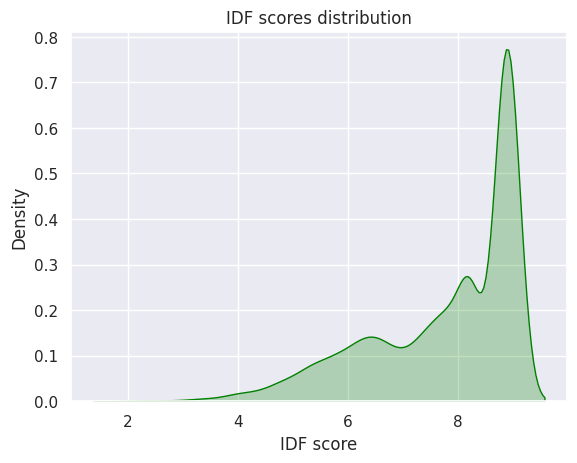

IDF scores average: 7.77556331644265
IDF scores median: 8.205628178501124
IDF scores min: 2.057159882583478
IDF scores max: 8.89877535906107


In [46]:
import math
from collections import Counter

# get the IDF scores for each word
# IDF(word) = log(N / count(word in documents))
# I will use the IDF scores computed on the training set (just the 'facts_and_question' column)
def calculate_idf(documents):
    N = len(documents)
    all_words = set()
    word_document_count = Counter() # count the number of documents that contain each word
    
    # Tokenize the documents and update the word_document_count
    for document in documents:
        words = set(document) # remove duplicates
        all_words.update(words)
        word_document_count.update(words) # increment the count for each word
    
    # Calculate the IDF score for each word
    idf_scores = {}
    for word in all_words:
        idf_scores[word] = math.log(N / word_document_count[word])
    
    return idf_scores

idf_scores = calculate_idf(df_train_tokenized['facts_and_question'])

# KDE plot of the IDF scores
sns.kdeplot(list(idf_scores.values()), fill=True, color='green')
plt.title('IDF scores distribution')
plt.xlabel('IDF score')
plt.ylabel('Density')
plt.show()
print('IDF scores average:', np.mean(list(idf_scores.values())))
print('IDF scores median:', np.median(list(idf_scores.values())))
print('IDF scores min:', np.min(list(idf_scores.values())))
print('IDF scores max:', np.max(list(idf_scores.values())))

idf_scores['UNK'] = np.median(list(idf_scores.values()))

I will use the median as an estimator for the unknown words. Is close to the max value of the idf scores, so it makes sense since an unknown word is quite rare...

In [47]:
def sent_to_emb_IDFweighted(sent, pretrained_vectors, idf_scores):
    vector_size = pretrained_vectors.vector_size 
    wv_res = np.zeros(vector_size)
    for w in sent:
        if w in pretrained_vectors:
            # add the word vector multiplied by the IDF score
            # if the word is not in the IDF scores, we use the median value (stored in 'UNK')
            wv_res += idf_scores.get(w, idf_scores['UNK']) * pretrained_vectors.get_vector(w)
    return wv_res

# I use this new weighted function to combine together the word vectors
sent_to_emb_IDFweighted_IDF = lambda x, y: sent_to_emb_IDFweighted(x, y, idf_scores)

print('word2vec-google-news-300 - IDF weighted - with duplicates\n')
pred_train_W2V = cosineSimilarity_predict(df_train_tokenized, pretrained_W2V, 
                                          sent_to_emb=sent_to_emb_IDFweighted_IDF)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')

print('')
pred_val_W2V = cosineSimilarity_predict(df_val_tokenized, pretrained_W2V, 
                                        sent_to_emb=sent_to_emb_IDFweighted_IDF)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')


word2vec-google-news-300 - IDF weighted - with duplicates



train Accuracy: 0.6707633483544995
train F1 Score: 0.6706853387365271

validation Accuracy: 0.6966707768187423
validation F1 Score: 0.6953039670245317


Now I try without duplicated words

In [48]:
print('word2vec-google-news-300 - IDF weighted - without duplicates\n')
pred_train_W2V = cosineSimilarity_predict(df_train_noDuplicates, pretrained_W2V,
                                            sent_to_emb=sent_to_emb_IDFweighted_IDF)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train_W2V, 'train')
print('')
pred_val_W2V = cosineSimilarity_predict(df_val_noDuplicates, pretrained_W2V,
                                        sent_to_emb=sent_to_emb_IDFweighted_IDF)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val_W2V, 'validation')

word2vec-google-news-300 - IDF weighted - without duplicates

train Accuracy: 0.781919978151031
train F1 Score: 0.781833493211076

validation Accuracy: 0.7990135635018496
validation F1 Score: 0.7983010189814015


The results are the same of the ones obtained with uniform weights (and no duplicated words).

---
# **Other ways of choosing the answer**

As representation of the documents I use the average of the word embeddings of the words in the sentence, without the duplicated words.

Before I have simply taken the choice with the maximum similarity with the question, but we can for example train a neural network which takes as input the question and the choice.

## Siamese Neural Network

Instead of just computing similarity between the question and the choices, train a SiameseNN to tell a part which choice is related to the question. We will learn the NN in such a way that will make closer as output the question and the correct choice.

I will not build a full NN (for example using LSTM with as inputs the raw data), I will just use linear layers for compering the output given by the Word2Vec embeddings. 

I will use the `torch.nn.CosineEmbeddingLoss`, which maximize the cosine similarity of two inputs when $y=1$, and minimize it if $y=-1$.

As input I will give directly the vectors obtained from embedding the sentences with the pretrained W2V model `'word2vec-google-news-300'`

![picture](../imgs/2_siameseoutput.png)

Training Data: create 8 samples for each question, one for each choice. Ss label I use 1 if the choice is correct, -1 otherwise. I will give for semplicity as input directly the embeddings (so I don't need to pad the sentences)

In [49]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# set the seed
seed = 8
set_seed(seed)

# set gpu as default device and float32 as default dtype
mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(mydevice) # default tensor device
torch.set_default_dtype(torch.float32) # default tensor dtype

#################################################################################

# first we create the training data
def create_training_data(df):
    # create 8 samples for each question
    df_train_nn = pd.DataFrame(columns=['facts_and_question', 'choice', 'label'])
    for i, row in df.iterrows():
        for choice in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
            # create a new row
            new_row = {}
            new_row['facts_and_question'] = row['facts_and_question']
            new_row['choice'] = row[choice]
            new_row['label'] = 1 if row['answerKey'] == choice else -1
            df_train_nn = pd.concat([df_train_nn, pd.DataFrame([new_row])], ignore_index=True)
    return df_train_nn

# data: tokenized data, w/o duplicated words
df_train_nn = df_train_noDuplicates.copy()
df_train_nn['answerKey'] = answerKey_train
df_train_nn = create_training_data(df_train_nn)
print(df_train_nn.head(8), '\n')

# get the Word2Vec embeddings
data_train_nn = {}
data_train_nn['facts_and_question'] = torch.tensor(df_train_nn['facts_and_question'].apply(lambda x: sent_to_emb(x, pretrained_W2V)))
data_train_nn['choice'] = torch.tensor(df_train_nn['choice'].apply(lambda x: sent_to_emb(x, pretrained_W2V)))
data_train_nn['label'] = torch.tensor(df_train_nn['label'])

print('shape data["facts_and_question"]: ', data_train_nn['facts_and_question'].shape)
print(data_train_nn['facts_and_question'][0][:10], '...')
print(data_train_nn['choice'][0][:10], '...')
print(data_train_nn['label'][0])

                                  facts_and_question      choice label
0  [formation, clouds, condensing, made, type, va...    [pearls]    -1
1  [formation, clouds, condensing, made, type, va...   [streams]    -1
2  [formation, clouds, condensing, made, type, va...    [shells]    -1
3  [formation, clouds, condensing, made, type, va...  [diamonds]    -1
4  [formation, clouds, condensing, made, type, va...      [rain]    -1
5  [formation, clouds, condensing, made, type, va...     [beads]     1
6  [formation, clouds, condensing, made, type, va...    [cooled]    -1
7  [formation, clouds, condensing, made, type, va...    [liquid]    -1 



/home/max/.pyenv/versions/3.12.3/envs/nlp-env/lib/python3.12/site-packages/torch/utils/_device.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return func(*args, **kwargs)


shape data["facts_and_question"]:  torch.Size([58584, 300])
tensor([ 0.0006,  0.0729,  0.0545, -0.0170, -0.1291, -0.0783, -0.0185, -0.1949,
         0.0500,  0.1072], device='cuda:0', dtype=torch.float64) ...
tensor([-0.0483, -0.0281,  0.0107,  0.0869,  0.0566, -0.0444, -0.0146, -0.2422,
        -0.0850,  0.2559], device='cuda:0', dtype=torch.float64) ...
tensor(-1, device='cuda:0')


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNN(nn.Module):
    def __init__(self, input_size):
        super(SiameseNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(64, 32)
        
    def forward_once(self, x):
        """Forward pass for one of the sentences -> MLP"""
        # Ensure input is 2D
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # the x input is already the embedding of the sentence (Word2Vec embedding)
        x = F.sigmoid(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.sigmoid(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.sigmoid(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.sigmoid(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return x
    
    def forward(self, input1, input2):
        """
        Forward pass for both sentences.
        The MLP is shared between the two sentences.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
   

Epoch 0, iter 0   - train_loss 0.4638, val_loss 0.8808
Epoch 0, iter 100 - train_loss 0.2321, val_loss 0.8734
Epoch 0, iter 200 - train_loss 0.232 , val_loss 0.8068
Epoch 1, iter 0   - train_loss 0.1834, val_loss 0.7415
Epoch 1, iter 100 - train_loss 0.1655, val_loss 0.4023
Epoch 1, iter 200 - train_loss 0.1819, val_loss 0.3251
Epoch 2, iter 0   - train_loss 0.2204, val_loss 0.3115
Epoch 2, iter 100 - train_loss 0.1797, val_loss 0.3197
Epoch 2, iter 200 - train_loss 0.2149, val_loss 0.3497
Epoch 3, iter 0   - train_loss 0.1917, val_loss 0.3187
Epoch 3, iter 100 - train_loss 0.203 , val_loss 0.3879
Epoch 3, iter 200 - train_loss 0.195 , val_loss 0.3537
Epoch 4, iter 0   - train_loss 0.1824, val_loss 0.3346
Epoch 4, iter 100 - train_loss 0.1972, val_loss 0.3928
Epoch 4, iter 200 - train_loss 0.1766, val_loss 0.3211
Epoch 5, iter 0   - train_loss 0.2044, val_loss 0.3583
Epoch 5, iter 100 - train_loss 0.1817, val_loss 0.3607
Epoch 5, iter 200 - train_loss 0.1827, val_loss 0.3115
Epoch 6, i

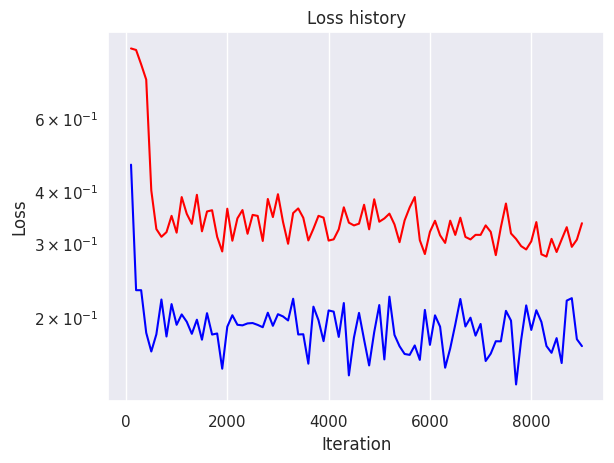

In [51]:
# HYPERPARAMETERS
embedding_dim = pretrained_W2V.vector_size
learning_rate = 1e-4
batch_size = 256 
epochs = 30

# Set the device
mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model 
model = SiameseNN(input_size=embedding_dim)
model.to(mydevice)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CosineEmbeddingLoss()

# create the DataLoader
train_data = torch.utils.data.TensorDataset(data_train_nn['facts_and_question'].float(), 
                                            data_train_nn['choice'].float(), 
                                            data_train_nn['label'].float())

generator = torch.Generator(device=mydevice)
generator.manual_seed(seed)

val_size = int(len(train_data) * 0.1)  # 10% of the train_data
train_size = len(train_data) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=generator)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)
# take a subset just for comparing the loss on unseen data
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# train the model
model.train()

counter = []
loss_history_train = [] 
loss_history_val = []
iteration_number = 0
for epoch in range(epochs):
    for i, (facts_and_question, choice, label) in enumerate(train_loader):
        # send the data to the device
        facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        output1, output2 = model(facts_and_question, choice)
        loss = loss_fn(output1, output2, label.float())

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # Every 100 batches print out the loss + save the loss
        if i % 100 == 0 :
            # compute the loss on the validation set
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for facts_and_question, choice, label in val_loader:
                    facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
                    output1, output2 = model(facts_and_question, choice)
                    val_loss += loss_fn(output1, output2, label.float())
                val_loss /= len(val_loader) # average loss

            print(f"Epoch {epoch}, iter {i:<3} - train_loss {round(loss.item(),4):<6}, val_loss {round(val_loss.item(),4)}")
            iteration_number += 100
            counter.append(iteration_number)
            loss_history_train.append(loss.item())
            loss_history_val.append(val_loss.item())
            model.train()

# SAVE THE MODEL
# torch.save(model.state_dict(), '../models/W2V_SiameseNN.model')

# loss history plot
sns.lineplot(x=counter, y=loss_history_train, color='blue')
sns.lineplot(x=counter, y=loss_history_val, color='red')
plt.yscale('log')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Now we have our pretrained model, now we just need to use it for this specific task. For each sample I will give as input to the model the question and each choice (one at a time), and then I will take the one with the highest cosine similarity with the question. The difference now wrt before is that we have a model that is **trained** for creating a lower dimensional embedding which is closer to the question, for the correct answer.

Use the pairs of <question, choice> (with the `forward()` method) is useful for the contrastive loss, now instead I will just run the `forward_once()` method for each input (so I get the representation).

In [52]:
def cosineSimilarity_predict_NeuralNetwork(df_tokenized, pretrained_vectors, model, sent_to_emb=sent_to_emb):
    model.eval()
    
    # the prediction method is the same, I just have one more block in the encoder
    ### SENTENCE TO EMBEDDING ### 

    # apply the function to all the cols of the dataframe
    columns_to_embed = ['facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    df_emb = dict()
    for col in columns_to_embed:
        df_emb[col] = df_tokenized[col].apply(
            # 1. get the embeddings (Word2Vec)
            # 2. transform them to torch tensors (device=mydevice, float)
            # 3. feed them to the NeuralNetwork (encode them)
            lambda x: model.forward_once(torch.tensor(sent_to_emb(x, pretrained_vectors)).float().to(mydevice))
        )

    ### PREDICT ###

    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    # compute cosine similarity between 'facts_and_question' and each choice column
    similarity_scores = {}
    for choice in choices:
        similarity_scores[choice] = np.array([cosine_similarity_btw2vec(v1, v2) \
                                              for v1, v2 in zip(df_emb['facts_and_question'], df_emb[choice])])
    # convert the dictionary to a DataFrame (so we navigate along the rows)
    similarity_scores = pd.DataFrame(similarity_scores)
    # find the choice with the highest cosine similarity
    # since we have a pandas DataFrame, the argmax returns the column name ('A', 'B', 'C', ...)
    predicted_choices = similarity_scores.idxmax(axis=1)
    return predicted_choices

In [53]:
# LOAD THE MODEL
model = SiameseNN(input_size=300)
model.load_state_dict(torch.load('../models/W2V_SiameseNN.model', weights_only=True, map_location=mydevice))

model.eval()

pred_train = cosineSimilarity_predict_NeuralNetwork(df_train_noDuplicates, pretrained_W2V, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train, 'train')
print('')
pred_val = cosineSimilarity_predict_NeuralNetwork(df_val_noDuplicates, pretrained_W2V, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val, 'validation')


train Accuracy: 0.47166461832582274
train F1 Score: 0.4715819357116793

validation Accuracy: 0.4599260172626387
validation F1 Score: 0.4578140373656785


## Feed Forward Neural Network

Instead of using a SiameseNN I will just apply a simple FeedForwardNN to the **difference between the question and one of the choice** (it is trained as a binary classification task, the correct choice have label 1, the others have value 0). 

As output I use a `sigmoid` function, and the `binary_cross_entropy` as loss function.

![picture](../imgs/2_ffnnoutput.png)

In [54]:
# the training data is the same, I just need to change the negative label from -1 to 0
data_train_ffnn = data_train_nn.copy()
data_train_ffnn['label'] = torch.where(data_train_ffnn['label'] == -1, 0, data_train_ffnn['label'])
print(data_train_ffnn['facts_and_question'][:8], '...')
print(data_train_ffnn['label'][:8])

tensor([[ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308],
        [ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308],
        [ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308],
        ...,
        [ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308],
        [ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308],
        [ 0.0006,  0.0729,  0.0545,  ...,  0.0729,  0.0357, -0.0308]],
       device='cuda:0', dtype=torch.float64) ...
tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


In [55]:
class Diff_FeedFarwardNN(nn.Module):
    def __init__(self, input_size):
        super(Diff_FeedFarwardNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(32, 1)


    def forward(self, x1, x2):
        """I take as input x1 and x2, then I take the difference between the two vectors"""

        x = x1 - x2

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = F.sigmoid(self.fc5(x))

        return x


Epoch 0  , iter 0   - train_loss 0.5799, val_loss 0.7139
Epoch 0  , iter 100 - train_loss 0.5443, val_loss 0.6681
Epoch 1  , iter 0   - train_loss 0.5478, val_loss 0.6664
Epoch 1  , iter 100 - train_loss 0.4956, val_loss 0.6492
Epoch 2  , iter 0   - train_loss 0.4862, val_loss 0.6468
Epoch 2  , iter 100 - train_loss 0.4562, val_loss 0.6291
Epoch 3  , iter 0   - train_loss 0.4736, val_loss 0.6256
Epoch 3  , iter 100 - train_loss 0.4338, val_loss 0.6099
Epoch 4  , iter 0   - train_loss 0.4372, val_loss 0.6108
Epoch 4  , iter 100 - train_loss 0.4134, val_loss 0.5924
Epoch 5  , iter 0   - train_loss 0.3904, val_loss 0.5908
Epoch 5  , iter 100 - train_loss 0.4151, val_loss 0.579
Epoch 6  , iter 0   - train_loss 0.398 , val_loss 0.5793
Epoch 6  , iter 100 - train_loss 0.3941, val_loss 0.5666
Epoch 7  , iter 0   - train_loss 0.3991, val_loss 0.5669
Epoch 7  , iter 100 - train_loss 0.3586, val_loss 0.5568
Epoch 8  , iter 0   - train_loss 0.3566, val_loss 0.5561
Epoch 8  , iter 100 - train_loss

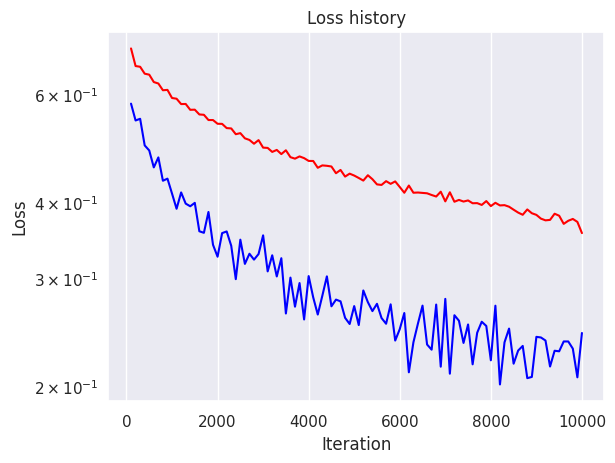

In [56]:
# HYPERPARAMETERS
embedding_dim = pretrained_W2V.vector_size
learning_rate = 1e-4
batch_size = 512 
epochs = 50

# Set the device
mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model 
model = Diff_FeedFarwardNN(input_size=embedding_dim)
model.to(mydevice)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# create the DataLoader
train_data = torch.utils.data.TensorDataset(data_train_ffnn['facts_and_question'].float(), 
                                            data_train_ffnn['choice'].float(), 
                                            data_train_ffnn['label'].float())

generator = torch.Generator(device=mydevice)
val_size = int(len(train_data) * 0.1)  # 10% of the train_data
train_size = len(train_data) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=generator)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)
# take a subset just for comparing the loss on unseen data
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# train the model
model.train()

counter = []
loss_history_train = [] 
loss_history_val = []
iteration_number = 0
for epoch in range(epochs):
    for i, (facts_and_question, choice, label) in enumerate(train_loader):
        # send the data to the device
        facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(facts_and_question, choice)
        loss = loss_fn(output, label.float().unsqueeze(1))

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # Every 100 batches print out the loss + save the loss
        if i % 100 == 0 :
            # compute the loss on the validation set
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for facts_and_question, choice, label in val_loader:
                    facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
                    output = model(facts_and_question, choice)
                    val_loss += loss_fn(output, label.float().unsqueeze(1))
                val_loss /= len(val_loader) # average loss

            print(f"Epoch {epoch:<3}, iter {i:<3} - train_loss {round(loss.item(),4):<6}, val_loss {round(val_loss.item(),4)}")
            iteration_number += 100
            counter.append(iteration_number)
            loss_history_train.append(loss.item())
            loss_history_val.append(val_loss.item())
            model.train()

# SAVE THE MODEL
# torch.save(model.state_dict(), '../models/W2V_Diff_FFNN.model')

# loss history plot
# the validation loss is smoother because it is computed on the whole validation set
# the training loss is computed on the training mini-batch
sns.lineplot(x=counter, y=loss_history_train, color='blue')
sns.lineplot(x=counter, y=loss_history_val, color='red')
plt.yscale('log')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

I have trained the model to make closer to the class 1 the output given by the difference of the vectors *<question, correct choice>* (and close to 0 the pairs *<question, wrong choice>*). Now I just need to feed the model, and I take as prediction the output which is closer to 1 between the 8 choices (`argmax`)

In [57]:
def argmax_predict_NeuralNetwork(df, pretrained_vectors, model):
    model.eval()
    
    # get the Word2Vec embeddings and transform them to torch tensors
    data = {}
    for col in ['facts_and_question', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        # Apply the sent_to_emb function and stack the results into a tensor
        data[col] = torch.stack(df[col].apply(lambda x: torch.tensor(sent_to_emb(x, pretrained_vectors)).float().to(mydevice)).tolist())
    
    # Apply the model to the data
    output = model(data['facts_and_question'], data['A'])
    for col in ['B', 'C', 'D', 'E', 'F', 'G', 'H']:
        output = torch.cat((output, model(data['facts_and_question'], data[col])), dim=1)

    predicted_choices = torch.argmax(output, dim=1)
    # map the indexes to the choices
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    predicted_choices = predicted_choices.cpu().detach().numpy()
    predicted_choices = [choices[i] for i in predicted_choices]
    predicted_choices = pd.Series(predicted_choices)
    return predicted_choices

In [58]:
# LOAD THE MODEL
model = Diff_FeedFarwardNN(input_size=300)
model.load_state_dict(torch.load('../models/W2V_Diff_FFNN.model', weights_only=True, map_location=mydevice))

model.eval()

pred_train = argmax_predict_NeuralNetwork(df_train_noDuplicates, pretrained_W2V, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train, 'train')
print('')
pred_val = argmax_predict_NeuralNetwork(df_val_noDuplicates, pretrained_W2V, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val, 'validation')


train Accuracy: 0.9078246620237608
train F1 Score: 0.9077555375541766

validation Accuracy: 0.7632552404438965
validation F1 Score: 0.7626933226570123


There is a very high overfitting, but at the accuracy on validation is much higher wrt the result with the SiameseNN.

Before I have taken the difference between the two input documents, now I try to **concatenate** them and apply a (bigger) linear layer.

In [59]:
class Concat_FeedFarwardNN(nn.Module):
    def __init__(self, input_size):
        super(Concat_FeedFarwardNN, self).__init__()

        # self.fc4 = nn.Linear(64, 1)
        self.fc1 = nn.Linear(input_size*2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(32, 1)

    def forward(self, x1, x2):
        """I take as input x1 and x2, then I concatenate the two vectors"""

        x = torch.cat((x1, x2), dim=1)

        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = F.sigmoid(self.fc4(x))

        return x


Epoch 0  , iter 0   - train_loss 0.7675, val_loss 0.7529
Epoch 1  , iter 0   - train_loss 0.7492, val_loss 0.7388
Epoch 2  , iter 0   - train_loss 0.7107, val_loss 0.7172
Epoch 3  , iter 0   - train_loss 0.6818, val_loss 0.6972
Epoch 4  , iter 0   - train_loss 0.6523, val_loss 0.6783
Epoch 5  , iter 0   - train_loss 0.617 , val_loss 0.6588
Epoch 6  , iter 0   - train_loss 0.5917, val_loss 0.6427
Epoch 7  , iter 0   - train_loss 0.5616, val_loss 0.6238
Epoch 8  , iter 0   - train_loss 0.554 , val_loss 0.6057
Epoch 9  , iter 0   - train_loss 0.5228, val_loss 0.5888
Epoch 10 , iter 0   - train_loss 0.5306, val_loss 0.5708
Epoch 11 , iter 0   - train_loss 0.5198, val_loss 0.5551
Epoch 12 , iter 0   - train_loss 0.4842, val_loss 0.5403
Epoch 13 , iter 0   - train_loss 0.5006, val_loss 0.5265
Epoch 14 , iter 0   - train_loss 0.4751, val_loss 0.5133
Epoch 15 , iter 0   - train_loss 0.4499, val_loss 0.5007
Epoch 16 , iter 0   - train_loss 0.4371, val_loss 0.4911
Epoch 17 , iter 0   - train_los

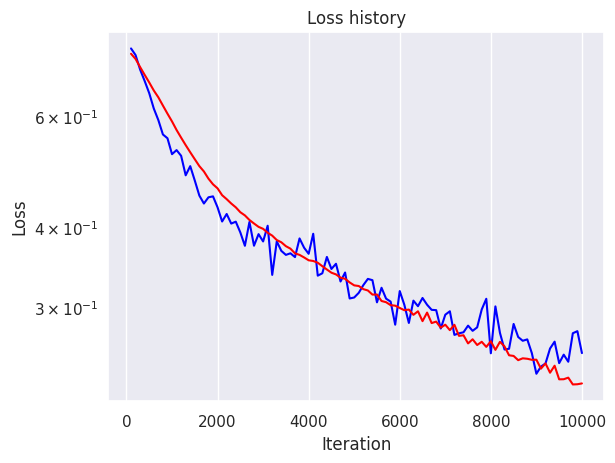

In [60]:
# HYPERPARAMETERS
embedding_dim = pretrained_W2V.vector_size
learning_rate = 1e-4
batch_size = 1024 
epochs = 100

# Set the device
mydevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model 
model = Concat_FeedFarwardNN(input_size=embedding_dim)
model.to(mydevice)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# create the DataLoader
train_data = torch.utils.data.TensorDataset(data_train_ffnn['facts_and_question'].float(), 
                                            data_train_ffnn['choice'].float(), 
                                            data_train_ffnn['label'].float())

generator = torch.Generator(device=mydevice)
val_size = int(len(train_data) * 0.1)  # 10% of the train_data
train_size = len(train_data) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size], generator=generator)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)
# take a subset just for comparing the loss on unseen data
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# train the model
model.train()

counter = []
loss_history_train = [] 
loss_history_val = []
iteration_number = 0
for epoch in range(epochs):
    for i, (facts_and_question, choice, label) in enumerate(train_loader):
        # send the data to the device
        facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(facts_and_question, choice)
        loss = loss_fn(output, label.float().unsqueeze(1))

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # Every 100 batches print out the loss + save the loss
        if i % 100 == 0 :
            # compute the loss on the validation set
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for facts_and_question, choice, label in val_loader:
                    facts_and_question, choice, label = facts_and_question.to(mydevice), choice.to(mydevice), label.to(mydevice)
                    output = model(facts_and_question, choice)
                    val_loss += loss_fn(output, label.float().unsqueeze(1))
                val_loss /= len(val_loader) # average loss

            print(f"Epoch {epoch:<3}, iter {i:<3} - train_loss {round(loss.item(),4):<6}, val_loss {round(val_loss.item(),4)}")
            iteration_number += 100
            counter.append(iteration_number)
            loss_history_train.append(loss.item())
            loss_history_val.append(val_loss.item())
            model.train()

# SAVE THE MODEL
# torch.save(model.state_dict(), '../models/W2V_Concat_FFNN.model')

# loss history plot
# the validation loss is smoother because it is computed on the whole validation set
# the training loss is computed on the training mini-batch
sns.lineplot(x=counter, y=loss_history_train, color='blue')
sns.lineplot(x=counter, y=loss_history_val, color='red')
plt.yscale('log')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [61]:
# LOAD THE MODEL
model = Concat_FeedFarwardNN(input_size=300)
model.load_state_dict(torch.load('../models/W2V_Concat_FFNN.model', weights_only=True, map_location=mydevice))

model.eval()

# the function is the same, I just need to change the model
pred_train = argmax_predict_NeuralNetwork(df_train_noDuplicates, pretrained_W2V, model)
train_accuracy, train_f1 = evaluate_predictions(answerKey_train, pred_train, 'train')
print('')
pred_val = argmax_predict_NeuralNetwork(df_val_noDuplicates, pretrained_W2V, model)
val_accuracy, val_f1 = evaluate_predictions(answerKey_val, pred_val, 'validation')

train Accuracy: 0.8687696299330875
train F1 Score: 0.868752565207096

validation Accuracy: 0.6781750924784217
validation F1 Score: 0.6768904445154131


This is worse than the previous one (wich simply compute the difference $x = x_1 - x_2$), but a little bit better than the Siamese one. Also the overfitting problem can be seen mainly only on our task, and not on the training of the neural network.

Ranking : 
1) Diff_FFNN : validation_acc = $0.763$
2) Concat_FFNN : validation_acc = $0.678$
3) SiameseNN : validation_acc = $0.459$

---

### **Best result notebook 2 -> W2V - cos_similarity - noDuplicates - IDF weighted**

`pretrained vectors = 'word2vec-google-news-300'`

From each sentence I have removed duplicated words (just one occurence for each word). The representation of the sentences is obteined by the weighted average of the word ebeddings, with the IDF score of each word as weight. The answer is chosen by taking the one with the highest cosine similarity with the `'facts_and_question'` entry.

| Metric          | Train     | Validation |
|-----------------|-----------|------------|
| Accuracy        | $0.78191$ | $0.79901$  |
| F1 Score        | $0.78183$ | $0.79830$  |

The IDF weights gives a slight improvement wrt the result obtained by doing a simple average (the weights of each word are equal) of the word embeddings:

| Metric          | Train     | Validation |
|-----------------|-----------|------------|
| Accuracy        | $0.77236$ | $0.78051$  |
| F1 Score        | $0.77223$ | $0.77936$  |

The main improvement wrt the other results is given by removing duplicated words (more than the idf weighting).